# Apresentação Séries Temporais

- Nathan Carlos
- Gregory Filipe

# Séries Temporais: previsão de ações com ETS
Adriano Marcos Rodrigues Figueiredo, *e-mail: adriano.figueiredo@ufms.br*
03 setembro 2019
Abstract

This is an undergrad student level instruction for class use.
Licença
This work is licensed under the Creative Commons Attribution-ShareAlike 4.0 International License. To view a copy of this license, visit http://creativecommons.org/licenses/by-sa/4.0/ or send a letter to Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.

License: CC BY-SA 4.0
License: CC BY-SA 4.0

# Citação
Sugestão de citação: FIGUEIREDO, Adriano Marcos Rodrigues. Séries Temporais: previsão de ações com ETS. Campo Grande-MS,Brasil: RStudio/Rpubs, 2019. Disponível em http://rpubs.com/amrofi/stocks_ETS.

# 2 Dados e gráfico

## 2.1 VALE3 e PETR4

In [ ]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
%%R
install.packages("ggplot2")
install.packages("quantmod")
install.packages("scales")
install.packages("ggthemes")
install.packages("gridExtra")
install.packages("dygraphs")
install.packages("fpp2")
install.packages("Metrics")
install.packages("forecast")
install.packages("sweep")


R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/ggplot2_3.3.5.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 3063309 bytes (2.9 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wri

In [ ]:
%%R
library(quantmod)
library(ggplot2)
library(scales)
library(ggthemes)
library(gridExtra)  # para vaios graficos juntos
library(dygraphs)  # para os graficos dinamicos
library(fpp2)  # para fazer o ETS
library(Metrics)  # para fazer acurácia
library(forecast)
library(sweep)

In [ ]:
%%R
  # para fazer acurácia
env = new.env()

In [ ]:
%%R
# pegando cotações mensais da petrobras e do ibovespa
getSymbols(c("PETR4.SA", "VALE3.SA"), src = "yahoo", env = env, periodicity = "monthly", 
    from = "2000-01-01", to = "2021-5-01")

[1] "PETR4.SA" "VALE3.SA"


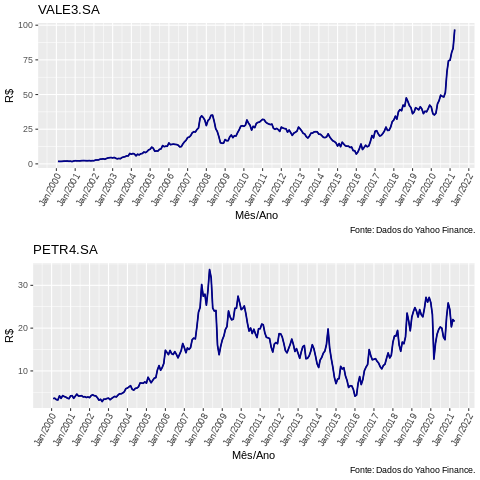

In [ ]:
%%R
vale = env$VALE3.SA[, 6]
petro = env$PETR4.SA[, 6]

g1 <- autoplot(vale) + geom_line(size = 0.8, colour = "darkblue") + scale_x_date(date_breaks = "12 months", 
    labels = date_format("%b/%Y")) + theme(axis.text.x = element_text(angle = 60, 
    vjust = 1, hjust = 1)) + labs(title = "VALE3.SA", caption = "Fonte: Dados do Yahoo Finance.") + 
    xlab("Mês/Ano") + ylab("R$")

g2 <- autoplot(petro) + geom_line(size = 0.8, colour = "darkblue") + scale_x_date(date_breaks = "12 months", 
    labels = date_format("%b/%Y")) + theme(axis.text.x = element_text(angle = 60, 
    vjust = 1, hjust = 1)) + labs(title = "PETR4.SA", caption = "Fonte: Dados do Yahoo Finance.") + 
    xlab("Mês/Ano") + ylab("R$")
# os dois graficos de cotacoes juntos
grid.arrange(g1, g2, nrow = 2)

## 2.2 Checando a periodicidade dos dados

In [ ]:
%%R
periodicity(petro)

Monthly periodicity from 2000-02-01 to 2021-04-01 


In [ ]:
%%R
periodicity(vale)

Monthly periodicity from 2000-02-01 to 2021-04-01 


## 2.3 Retornos mensais PETR4 e VALE3 com base no preço ajustado

In [ ]:
%%R
r_petro <- monthlyReturn(petro, type = "log")[-1, ]
r_vale <- monthlyReturn(vale, type = "log")[-1, ]

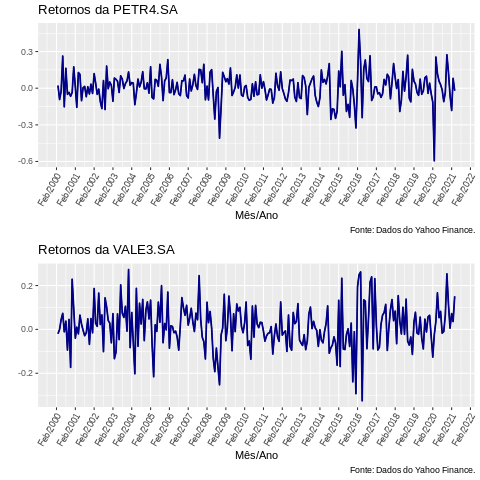

In [ ]:
%%R
g3 <- autoplot(r_petro) + geom_line(size = 0.8, colour = "darkblue") + scale_x_date(date_breaks = "12 months", 
    labels = date_format("%b/%Y")) + theme(axis.text.x = element_text(angle = 60, 
    vjust = 1, hjust = 1)) + labs(title = "Retornos da PETR4.SA", caption = "Fonte: Dados do Yahoo Finance.") + 
    xlab("Mês/Ano") + ylab("")

g4 <- autoplot(r_vale) + geom_line(size = 0.8, colour = "darkblue") + scale_x_date(date_breaks = "12 months", 
    labels = date_format("%b/%Y")) + theme(axis.text.x = element_text(angle = 60, 
    vjust = 1, hjust = 1)) + labs(title = "Retornos da VALE3.SA", caption = "Fonte: Dados do Yahoo Finance.") + 
    xlab("Mês/Ano") + ylab("")
# os dois graficos de cotacoes juntos
grid.arrange(g3, g4, nrow = 2)

# 3 Forecast

## 3.1 Delimitando treino x teste

In [ ]:
%%R
# transformando em ts
r_petro <- ts(petro, start = c(2000, 1), frequency = 12)
r_vale <- ts(vale, start = c(2000, 1), frequency = 12)

# treino até setembro 2015 (225 meses)
r_petro_treino <- window(r_petro, start = c(2000, 1), end = c(2020, 1))
r_vale_treino <- window(r_vale, start = c(2000, 1), end = c(2020, 1))
# teste (15 meses até agosto 2021)
r_petro_teste <- window(r_petro, start = c(2020, 2), end = c(2021, 5))
r_vale_teste <- window(r_vale, start = c(2020, 2), end = c(2021, 5))

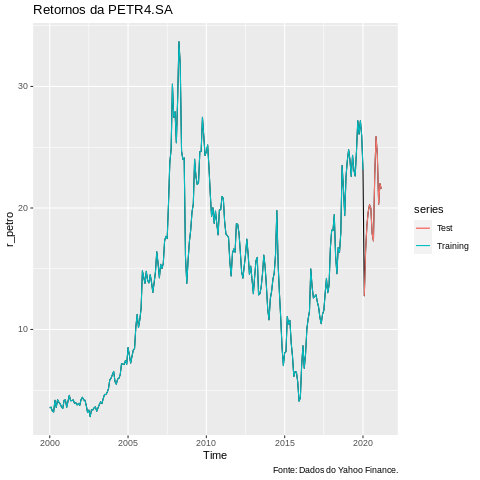

In [ ]:
%%R
autoplot(r_petro) + labs(title = "Retornos da PETR4.SA", caption = "Fonte: Dados do Yahoo Finance.") + 
    autolayer(r_petro_treino, series = "Training") + autolayer(r_petro_teste, 
    series = "Test")

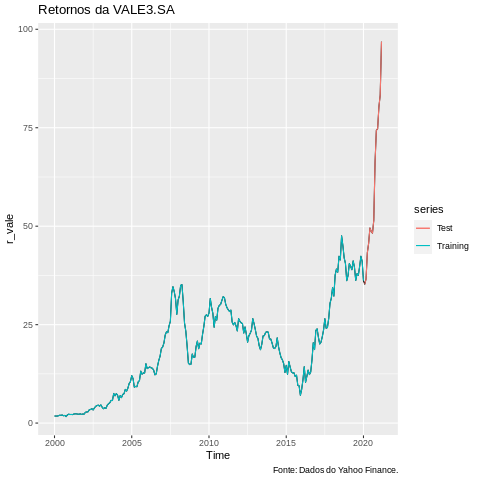

In [ ]:
%%R
autoplot(r_vale) + labs(title = "Retornos da VALE3.SA", caption = "Fonte: Dados do Yahoo Finance.") + 
    autolayer(r_vale_treino, series = "Training") + autolayer(r_vale_teste, 
    series = "Test")

## 3.2 Holt-Winters

In [ ]:
%%R
petro.hw <- forecast::hw(r_petro_treino, h = 20, seasonal = "additive")
summary(petro.hw)


Forecast method: Holt-Winters' additive method

Model Information:
Holt-Winters' additive method 

Call:
 forecast::hw(y = r_petro_treino, h = 20, seasonal = "additive") 

  Smoothing parameters:
    alpha = 0.9999 
    beta  = 1e-04 
    gamma = 1e-04 

  Initial states:
    l = 3.3599 
    b = 0.0807 
    s = 0.0699 0.1469 -0.1708 0.2396 -0.1261 -0.2679
           -0.5133 -0.3301 -0.0381 0.3298 0.3545 0.3055

  sigma:  1.6629

     AIC     AICc      BIC 
1584.396 1587.140 1643.637 

Error measures:
                       ME     RMSE      MAE        MPE     MAPE      MASE
Training set 6.682427e-05 1.606712 1.121839 -0.7362859 8.796396 0.2825756
                  ACF1
Training set 0.1133381

Forecasts:
         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Feb 2020       23.26572 21.13468 25.39676 20.00657 26.52486
Mar 2020       23.32183 20.30812 26.33555 18.71276 27.93091
Apr 2020       23.03455 19.34340 26.72569 17.38943 28.67967
May 2020       22.82280 18.56045 27.08514 16.30

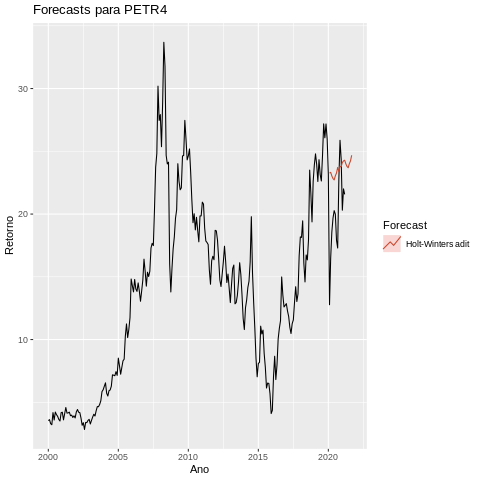

In [ ]:
%%R
autoplot(r_petro) + forecast::autolayer(petro.hw, series = "Holt-Winters adit", 
    PI = FALSE) + xlab("Ano") + ylab("Retorno") + ggtitle("Forecasts para PETR4") + 
    guides(colour = guide_legend(title = "Forecast"))

In [ ]:
%%R
# Holt-Winters vale
vale.hw <- forecast::hw(r_vale_treino, h = 20, seasonal = "additive")
summary(vale.hw)


Forecast method: Holt-Winters' additive method

Model Information:
Holt-Winters' additive method 

Call:
 forecast::hw(y = r_vale_treino, h = 20, seasonal = "additive") 

  Smoothing parameters:
    alpha = 0.9842 
    beta  = 6e-04 
    gamma = 0.013 

  Initial states:
    l = 1.768 
    b = 0.0806 
    s = -0.1316 0.1989 0.3171 -0.0463 0.0186 -0.4805
           -0.6519 -0.5374 -0.24 0.8923 0.2689 0.392

  sigma:  1.9115

     AIC     AICc      BIC 
1651.571 1654.315 1710.812 

Error measures:
                     ME    RMSE      MAE        MPE   MAPE      MASE       ACF1
Training set 0.05780742 1.84699 1.380993 -0.2383018 9.6254 0.2441167 0.08930009

Forecasts:
         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Feb 2020       36.18691 33.73718 38.63663 32.44037 39.93344
Mar 2020       36.85656 33.41848 40.29465 31.59846 42.11467
Apr 2020       36.01413 31.81335 40.21491 29.58959 42.43867
May 2020       35.66466 30.81910 40.51022 28.25401 43.07531
Jun 2020       35.76637 30

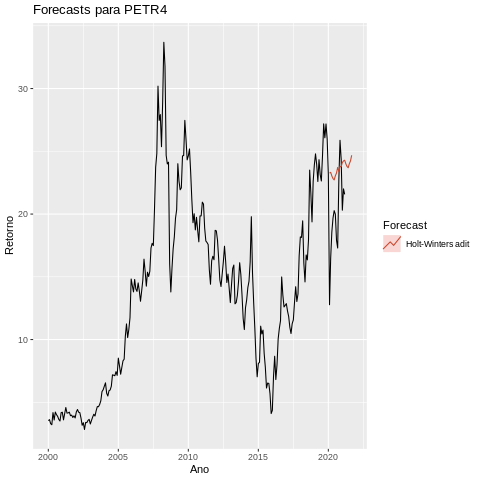

In [ ]:
%%R
autoplot(r_petro) + forecast::autolayer(petro.hw, series = "Holt-Winters adit", 
    PI = FALSE) + xlab("Ano") + ylab("Retorno") + ggtitle("Forecasts para PETR4") + 
    guides(colour = guide_legend(title = "Forecast"))

In [ ]:
%%R
vale.hw <- forecast::hw(r_vale_treino, h = 20, seasonal = "additive")
summary(vale.hw)


Forecast method: Holt-Winters' additive method

Model Information:
Holt-Winters' additive method 

Call:
 forecast::hw(y = r_vale_treino, h = 20, seasonal = "additive") 

  Smoothing parameters:
    alpha = 0.9842 
    beta  = 6e-04 
    gamma = 0.013 

  Initial states:
    l = 1.768 
    b = 0.0806 
    s = -0.1316 0.1989 0.3171 -0.0463 0.0186 -0.4805
           -0.6519 -0.5374 -0.24 0.8923 0.2689 0.392

  sigma:  1.9115

     AIC     AICc      BIC 
1651.571 1654.315 1710.812 

Error measures:
                     ME    RMSE      MAE        MPE   MAPE      MASE       ACF1
Training set 0.05780742 1.84699 1.380993 -0.2383018 9.6254 0.2441167 0.08930009

Forecasts:
         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Feb 2020       36.18691 33.73718 38.63663 32.44037 39.93344
Mar 2020       36.85656 33.41848 40.29465 31.59846 42.11467
Apr 2020       36.01413 31.81335 40.21491 29.58959 42.43867
May 2020       35.66466 30.81910 40.51022 28.25401 43.07531
Jun 2020       35.76637 30

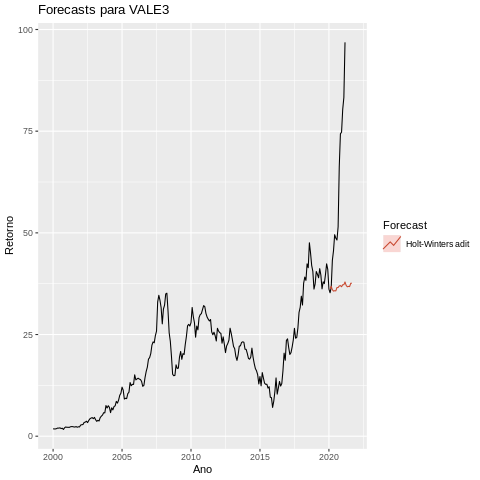

In [ ]:
%%R
autoplot(r_vale) + forecast::autolayer(vale.hw, series = "Holt-Winters adit", 
    PI = FALSE) + xlab("Ano") + ylab("Retorno") + ggtitle("Forecasts para VALE3") + 
    guides(colour = guide_legend(title = "Forecast"))

### 3.2.1 Acurácia

In [ ]:
%%R
Metrics::smape(r_petro_teste, petro.hw$mean)

[1] 0.1886848


In [ ]:
%%R
Metrics::smape(r_vale_teste, vale.hw$mean)

[1] 0.4284368


In [ ]:
%%R
Metrics::mape(r_petro_teste, petro.hw$mean)

[1] 0.2235587


In [ ]:
%%R
Metrics::mape(r_vale_teste, vale.hw$mean)

[1] 0.3318986


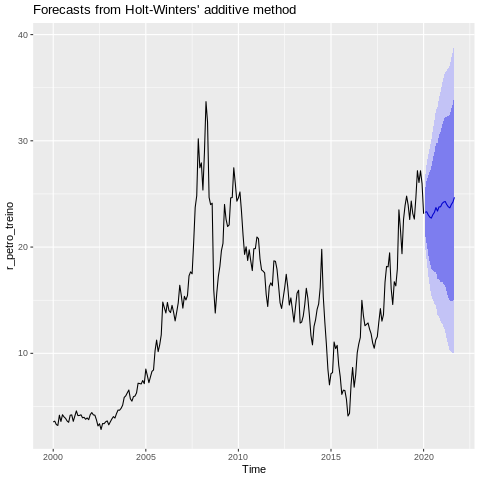

In [ ]:
%%R
autoplot(petro.hw)

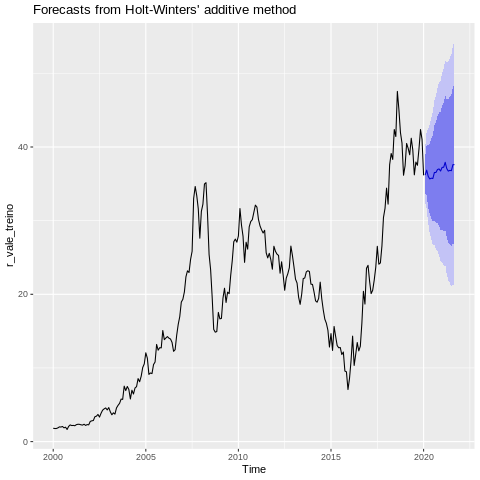

In [ ]:
%%R
autoplot(vale.hw)

## 3.3 ETS

In [ ]:
%%R
# ETS (error trend seasonal) de Hyndman - pacote fpp2
set.seed(123)
petro.ets <- ets(r_petro_treino, model = "ZZZ")  # N=none, A=additive, M=multiplicative e Z=automatic
summary(petro.ets)

ETS(M,A,N) 

Call:
 ets(y = r_petro_treino, model = "ZZZ") 

  Smoothing parameters:
    alpha = 0.9999 
    beta  = 1e-04 

  Initial states:
    l = 3.1165 
    b = 0.1457 

  sigma:  0.1138

     AIC     AICc      BIC 
1448.165 1448.421 1465.589 

Training set error measures:
                      ME     RMSE      MAE       MPE    MAPE     MASE      ACF1
Training set -0.06188927 1.620406 1.133072 -1.430949 8.75731 0.285405 0.1115465


In [ ]:
%%R
petro.ets.forecasts <- forecast.ets(petro.ets, h = 20)
summary(petro.ets.forecasts)


Forecast method: ETS(M,A,N)

Model Information:
ETS(M,A,N) 

Call:
 ets(y = r_petro_treino, model = "ZZZ") 

  Smoothing parameters:
    alpha = 0.9999 
    beta  = 1e-04 

  Initial states:
    l = 3.1165 
    b = 0.1457 

  sigma:  0.1138

     AIC     AICc      BIC 
1448.165 1448.421 1465.589 

Error measures:
                      ME     RMSE      MAE       MPE    MAPE     MASE      ACF1
Training set -0.06188927 1.620406 1.133072 -1.430949 8.75731 0.285405 0.1115465

Forecasts:
         Point Forecast     Lo 80    Hi 80      Lo 95    Hi 95
Feb 2020       23.27966 19.885480 26.67384 18.0887108 28.47061
Mar 2020       23.42383 18.593395 28.25427 16.0363149 30.81135
Apr 2020       23.56801 17.614432 29.52159 14.4627978 32.67322
May 2020       23.71218 16.794013 30.63036 13.1317536 34.29262
Jun 2020       23.85636 16.072655 31.64007 11.9522102 35.76051
Jul 2020       24.00054 15.420039 32.58103 10.8777983 37.12327
Aug 2020       24.14471 14.818260 33.47116  9.8811359 38.40828
Sep 2020

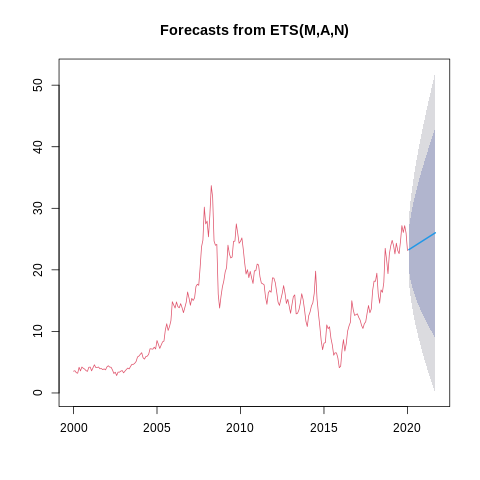

In [ ]:
%%R
plot(petro.ets.forecasts, col = 2)

In [ ]:
%%R
# ETS (error trend seasonal) de Hyndman - pacote fpp2
set.seed(123)
vale.ets <- ets(r_vale_treino, model="ZZZ", damped=FALSE)  # N=none, A=additive, M=multiplicative e Z=automatic
summary(vale.ets)

ETS(M,A,N) 

Call:
 ets(y = r_vale_treino, model = "ZZZ", damped = FALSE) 

  Smoothing parameters:
    alpha = 0.9646 
    beta  = 1e-04 

  Initial states:
    l = 1.6907 
    b = 0.1008 

  sigma:  0.1011

     AIC     AICc      BIC 
1488.103 1488.358 1505.527 

Training set error measures:
                     ME     RMSE      MAE        MPE     MAPE      MASE
Training set 0.04387441 1.852361 1.332454 -0.4231968 7.680478 0.2355365
                  ACF1
Training set 0.1060807


In [ ]:
%%R
vale.ets.forecasts <- forecast.ets(vale.ets, h = 20)
summary(vale.ets.forecasts)


Forecast method: ETS(M,A,N)

Model Information:
ETS(M,A,N) 

Call:
 ets(y = r_vale_treino, model = "ZZZ", damped = FALSE) 

  Smoothing parameters:
    alpha = 0.9646 
    beta  = 1e-04 

  Initial states:
    l = 1.6907 
    b = 0.1008 

  sigma:  0.1011

     AIC     AICc      BIC 
1488.103 1488.358 1505.527 

Error measures:
                     ME     RMSE      MAE        MPE     MAPE      MASE
Training set 0.04387441 1.852361 1.332454 -0.4231968 7.680478 0.2355365
                  ACF1
Training set 0.1060807

Forecasts:
         Point Forecast    Lo 80    Hi 80     Lo 95    Hi 95
Feb 2020       36.43431 31.71549 41.15312 29.217498 43.65112
Mar 2020       36.53649 29.95397 43.11900 26.469395 46.60358
Apr 2020       36.63866 28.59413 44.68320 24.335616 48.94171
May 2020       36.74084 27.44431 46.03738 22.523018 50.95867
Jun 2020       36.84302 26.42830 47.25774 20.915084 52.77096
Jul 2020       36.94520 25.50665 48.38375 19.451452 54.43895
Aug 2020       37.04738 24.65580 49.4389

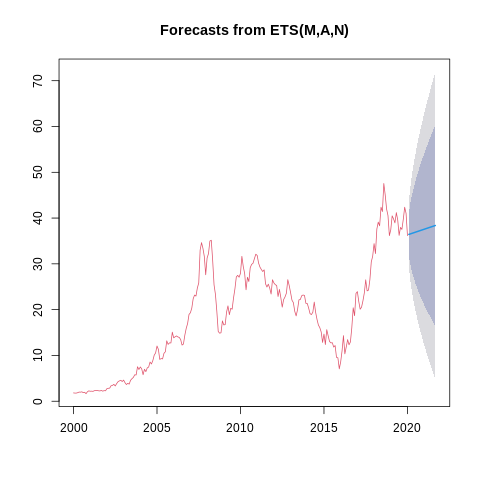

In [ ]:
%%R
plot(vale.ets.forecasts, col = 2)

In [ ]:
%%R
print(vale.ets.forecasts)

         Point Forecast    Lo 80    Hi 80     Lo 95    Hi 95
Feb 2020       36.43431 31.71549 41.15312 29.217498 43.65112
Mar 2020       36.53649 29.95397 43.11900 26.469395 46.60358
Apr 2020       36.63866 28.59413 44.68320 24.335616 48.94171
May 2020       36.74084 27.44431 46.03738 22.523018 50.95867
Jun 2020       36.84302 26.42830 47.25774 20.915084 52.77096
Jul 2020       36.94520 25.50665 48.38375 19.451452 54.43895
Aug 2020       37.04738 24.65580 49.43896 18.096099 55.99866
Sep 2020       37.14956 23.86038 50.43874 16.825507 57.47361
Oct 2020       37.25174 23.10968 51.39379 15.623333 58.88015
Nov 2020       37.35392 22.39595 52.31189 14.477683 60.23016
Dec 2020       37.45610 21.71331 53.19888 13.379584 61.53261
Jan 2021       37.55828 21.05721 54.05934 12.322077 62.79448
Feb 2021       37.66046 20.42404 54.89687 11.299636 64.02128
Mar 2021       37.76264 19.81087 55.71440 10.307787 65.21748
Apr 2021       37.86481 19.21531 56.51432  9.342851 66.38678
May 2021       37.96699 

### 3.3.1 Acurácia

In [ ]:
%%R
Metrics::smape(r_petro_teste, petro.ets.forecasts$mean)

[1] 0.2109661


In [ ]:
%%R
Metrics::smape(r_vale_teste, vale.ets.forecasts$mean)

[1] 0.4154142


In [ ]:
%%R
Metrics::mape(r_petro_teste, petro.ets.forecasts$mean)

[1] 0.2511228


In [ ]:
%%R
Metrics::mape(r_vale_teste, vale.ets.forecasts$mean)

[1] 0.3225216


# Rede Neural

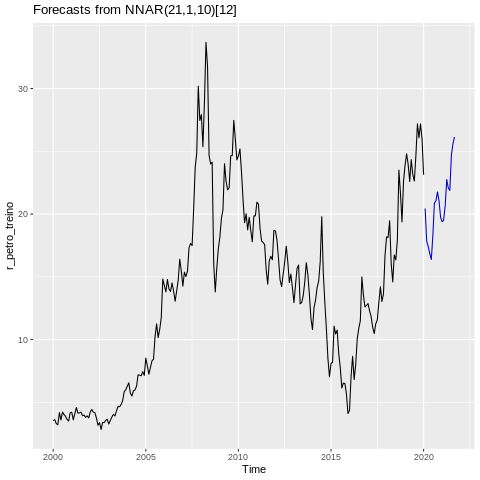

In [ ]:
%%R
set.seed(324)
modelo1 = nnetar(r_petro_treino,p=21,size=10,lambda=0.5,maxit=900)
modelo2 = nnetar(r_vale_treino,p=21,size=10,lambda=0.5,maxit=900)

prev1 = forecast(modelo1, h=20)
prev2 = forecast(modelo2, h=20)
autoplot(prev1)

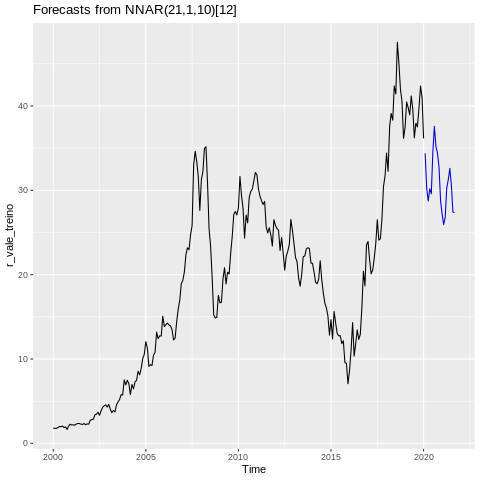

In [ ]:
%%R
autoplot(prev2)

### Comparação da Acuracia

#### NNETAR

In [ ]:
%%R
print(paste("SMAPE petro: ",Metrics::smape(r_petro_teste, prev1$mean)))
print(paste("SMAPE vale: ", Metrics::smape(r_vale_teste, prev2$mean)))

[1] "SMAPE petro:  0.14867882702441"
[1] "SMAPE vale:  0.568756490519889"


In [ ]:
%%R
print(paste("MAPE petro: ",Metrics::mape(r_petro_teste, prev1$mean)))
print(paste("MAPE vale: ", Metrics::mape(r_vale_teste, prev2$mean)))

[1] "MAPE petro:  0.155085224690086"
[1] "MAPE vale:  0.416461046288233"


In [ ]:
%%R
print(paste("MASE petro: ",Metrics::mase(r_petro_teste, prev1$mean)))
print(paste("MASE vale: ", Metrics::mase(r_vale_teste, prev2$mean)))

[1] "MASE petro:  1.39206300166757"
[1] "MASE vale:  5.7597664747208"


#### Holt-Winters

In [ ]:
%%R
print(paste("SMAPE petro: ",Metrics::smape(r_petro_teste, petro.hw$mean)))
print(paste("SMAPE vale: ", Metrics::smape(r_vale_teste, vale.hw$mean)))

[1] "SMAPE petro:  0.188684778859973"
[1] "SMAPE vale:  0.428436809016677"


In [ ]:
%%R
print(paste("MAPE petro: ",Metrics::mape(r_petro_teste, petro.hw$mean)))
print(paste("MAPE vale: ", Metrics::mape(r_vale_teste, vale.hw$mean)))

[1] "MAPE petro:  0.223558708034226"
[1] "MAPE vale:  0.331898564197969"


In [ ]:
%%R
print(paste("MASE petro: ",Metrics::mase(r_petro_teste, petro.hw$mean)))
print(paste("MASE vale: ", Metrics::mase(r_vale_teste, vale.hw$mean)))

[1] "MASE petro:  1.88462898555407"
[1] "MASE vale:  4.69395955548488"


#### ETS

In [ ]:
%%R
print(paste0("SMAPE petro: ",Metrics::smape(r_petro_teste, petro.ets.forecasts$mean)))
print(paste0("SMAPE vale: ", Metrics::smape(r_vale_teste, vale.ets.forecasts$mean)))

[1] "SMAPE petro: 0.210966128201005"
[1] "SMAPE vale: 0.415414152863739"


In [ ]:
%%R
print(paste0("MAPE petro: ",Metrics::mape(r_petro_teste, petro.ets.forecasts$mean)))
print(paste0("MAPE vale: ", Metrics::mape(r_vale_teste, vale.ets.forecasts$mean)))

[1] "MAPE petro: 0.251122776013201"
[1] "MAPE vale: 0.322521625755864"


In [ ]:
%%R
print(paste0("MASE petro: ",Metrics::mase(r_petro_teste, petro.ets.forecasts$mean)))
print(paste0("MASE vale: ", Metrics::mase(r_vale_teste, vale.ets.forecasts$mean)))

[1] "MASE petro: 2.14501294669401"
[1] "MASE vale: 4.59290700530304"


#### Plots Conjuntos

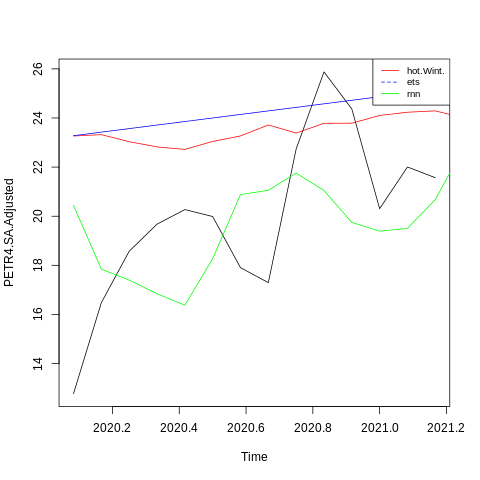

In [ ]:
%%R
plot(r_petro_teste)
lines(petro.hw$mean, col="red")
lines(petro.ets.forecasts$mean, col="blue")
lines(prev1$mean, col="green")
legend("topright",legend=c("hot.Wint.","ets","rnn"), col = c("red","blue","green"), lty=1:2, cex=0.8)


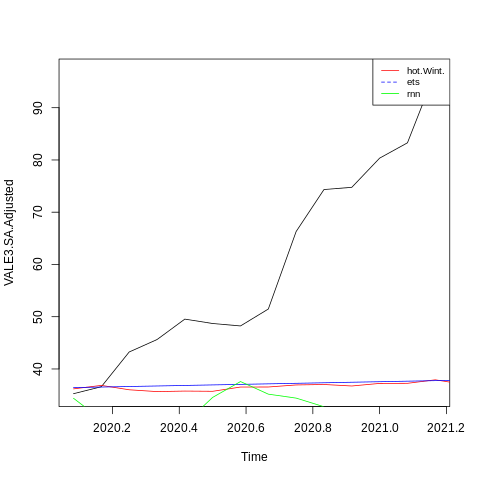

In [ ]:
%%R
plot(r_vale_teste)
lines(vale.hw$mean, col="red")
lines(vale.ets.forecasts$mean, col="blue")
lines(prev2$mean, col="green")
legend("topright",legend=c("hot.Wint.","ets","rnn"), col = c("red","blue","green"), lty=1:2, cex=0.8)
